# How to Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference



1. file name Img2000cls5TrainTest.zip <br>
in my computer <br>
POC/FourBatch/FINALbatch4class5/Img2000cls5TrainTest


#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r yolov5/requirements.txt  # install dependencies
%cd yolov5



Cloning into 'yolov5'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 666 (delta 33), reused 35 (delta 14), pack-reused 600
Receiving objects: 100% (666/666), 3.36 MiB | 6.14 MiB/s, done.
Resolving deltas: 100% (426/426), done.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-wberop6l
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-wberop6l
     |████████████████████████████████| 20.4MB 1.2MB/s 
     |████████████████████████████████| 276kB 51.2MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=052fbf58d2b18d3fb2292f0a02b665b996ebd732e46cfdd86b7ce91badb2aabb
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266999 sha25

/content/yolov5


In [ ]:
import torch
from IPython.display import Image  # to display images   clear_output
from utils.google_utils import gdrive_download  # to download models/datasets
import yaml

#clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Download Correctly Formatted Custom Dataset 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
# Export code snippet and paste here
# %cd /content
# !curl -L "https://public.roboflow.ai/ds/YOUR DATASET HERE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


In [ ]:
%cd ..

/content


In [ ]:
# !rm -rf handiParkData/
!unzip Img2000cls5TrainTest.zip
#!tar -xvf data-batch1.tgz

Archive:  Img2000cls5TrainTest.zip
   creating: Img2000cls5TrainTest/
   creating: Img2000cls5TrainTest/testyolo/
  inflating: Img2000cls5TrainTest/.DS_Store  
  inflating: __MACOSX/Img2000cls5TrainTest/._.DS_Store  
   creating: Img2000cls5TrainTest/trainyolo/
  inflating: Img2000cls5TrainTest/testyolo/.DS_Store  
  inflating: __MACOSX/Img2000cls5TrainTest/testyolo/._.DS_Store  
   creating: Img2000cls5TrainTest/testyolo/images/
   creating: Img2000cls5TrainTest/testyolo/labels/
  inflating: Img2000cls5TrainTest/trainyolo/.DS_Store  
  inflating: __MACOSX/Img2000cls5TrainTest/trainyolo/._.DS_Store  
   creating: Img2000cls5TrainTest/trainyolo/images/
   creating: Img2000cls5TrainTest/trainyolo/labels/
  inflating: Img2000cls5TrainTest/testyolo/images/39.74099302--104.98912709999999-45.jpg  
  inflating: Img2000cls5TrainTest/testyolo/images/39.75951031--104.97353729999999-135.jpg  
  inflating: Img2000cls5TrainTest/testyolo/images/39.751665700000004--104.9933563-225.jpg  
  inflating: 

In [ ]:
data = {"train": "Img2000cls5TrainTest/trainyolo/images", 
        "val": "Img2000cls5TrainTest/testyolo/images",
        "nc": 5,
        "names": ["lamp","sign-h","fh","nopark","stop"]}
%cd /content/
with open("data.yaml", "w") as fname:
  yaml.dump(data, fname)



/content


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

names:
- lamp
- sign-h
- fh
- nopark
- stop
nc: 5
train: Img2000cls5TrainTest/trainyolo/images
val: Img2000cls5TrainTest/testyolo/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cd /content/
##write custom model .yaml
#you can configure this based on other YOLOv5 models in the models directory
with open('yolov5/models/custom_yolov5s.yaml', 'w') as f:
  # parameters
  f.write('nc: ' + num_classes + '\n')
  #f.write('nc: ' + str(len(class_labels)) + '\n')
  f.write('depth_multiple: 0.33'  + '\n') # model depth multiple
  f.write('width_multiple: 0.50'  + '\n')  # layer channel multiple
  f.write('\n')
  f.write('anchors:' + '\n')
  f.write('  - [10,13, 16,30, 33,23] ' + '\n')
  f.write('  - [30,61, 62,45, 59,119]' + '\n')
  f.write('  - [116,90, 156,198, 373,326] ' + '\n')
  f.write('\n')

  f.write('backbone:' + '\n')
  f.write('  [[-1, 1, Focus, [64, 3]],' + '\n')
  f.write('   [-1, 1, Conv, [128, 3, 2]],' + '\n')
  f.write('   [-1, 3, Bottleneck, [128]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 3, 2]],' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [256]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 3, 2]], ' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [512]],' + '\n')
  f.write('   [-1, 1, Conv, [1024, 3, 2]],' + '\n')
  f.write('   [-1, 1, SPP, [1024, [5, 9, 13]]],' + '\n')
  f.write('   [-1, 6, BottleneckCSP, [1024]],' + '\n')
  f.write('  ]' + '\n')
  f.write('\n')

  f.write('head:'  + '\n')
  f.write('  [[-1, 3, BottleneckCSP, [1024, False]],'  + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  
  f.write('   [[-1, 6], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [512, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  f.write('   [[-1, 4], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [256, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('\n' )
  f.write('   [[], 1, Detect, [nc, anchors]],' + '\n')
  f.write('  ]' + '\n')

print('custom model config written!')

/content
custom model config written!


# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
!cp -r /content/Img2000cls5TrainTest /content/yolov5

In [ ]:
# train yolov5s on custom data for 50 epochs
# time its performance
%%time
%cd /content/yolov5/
# !python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results --nosave --cache
#default is yolo5s.pt
!python train.py --img 416 --batch 16 --epochs 130 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights ./weights/yolov5s.pt --name Img2000cls5_results --cache

/content/yolov5
Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', epochs=130, evolve=False, img_size=[416], multi_scale=False, name='Img2000cls5_results', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='./weights/yolov5s.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

2020-06-20 20:59:57.310676: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Start Tensorboard with "tensor

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
#%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

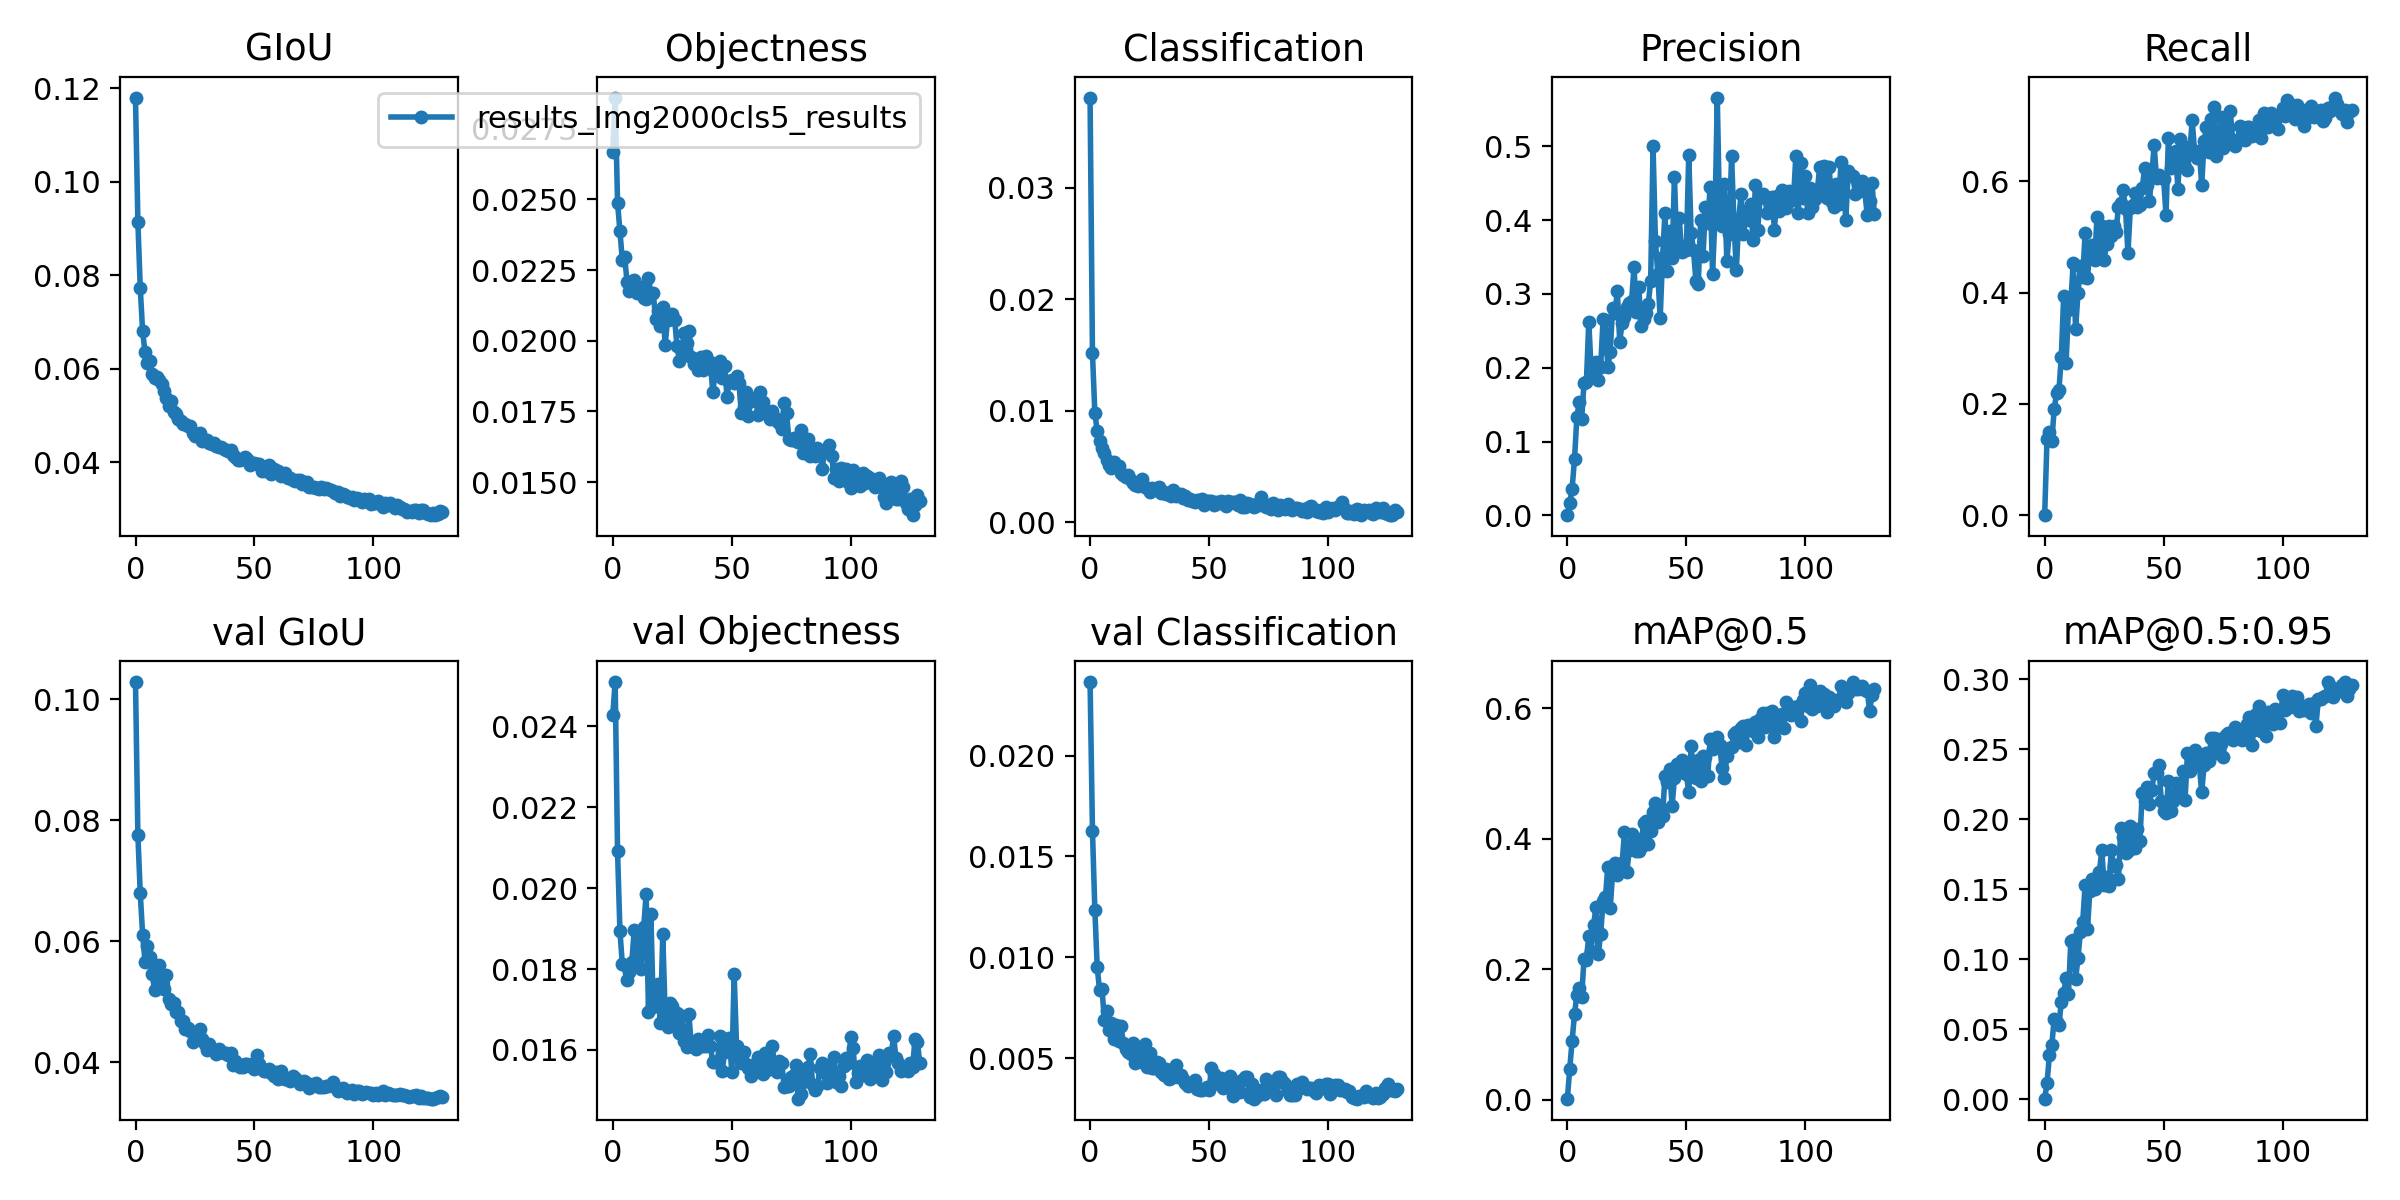

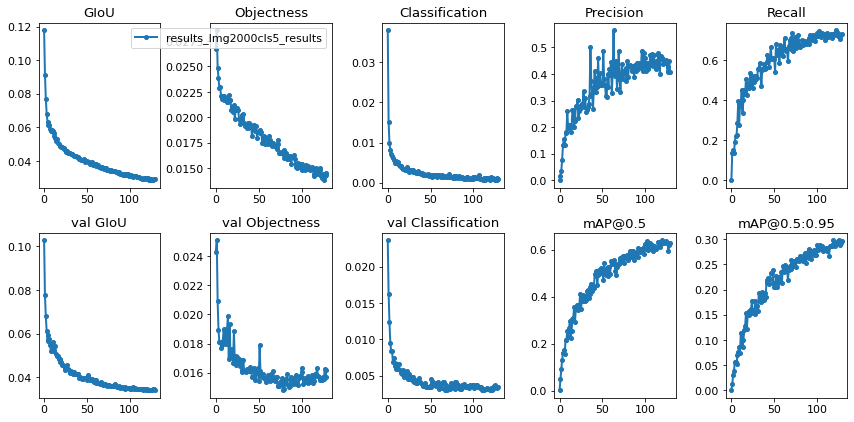

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.utils import plot_results; plot_results()  # plot results.txt as results.png
Image(filename='./results.png', width=1000)  # view results.png


### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


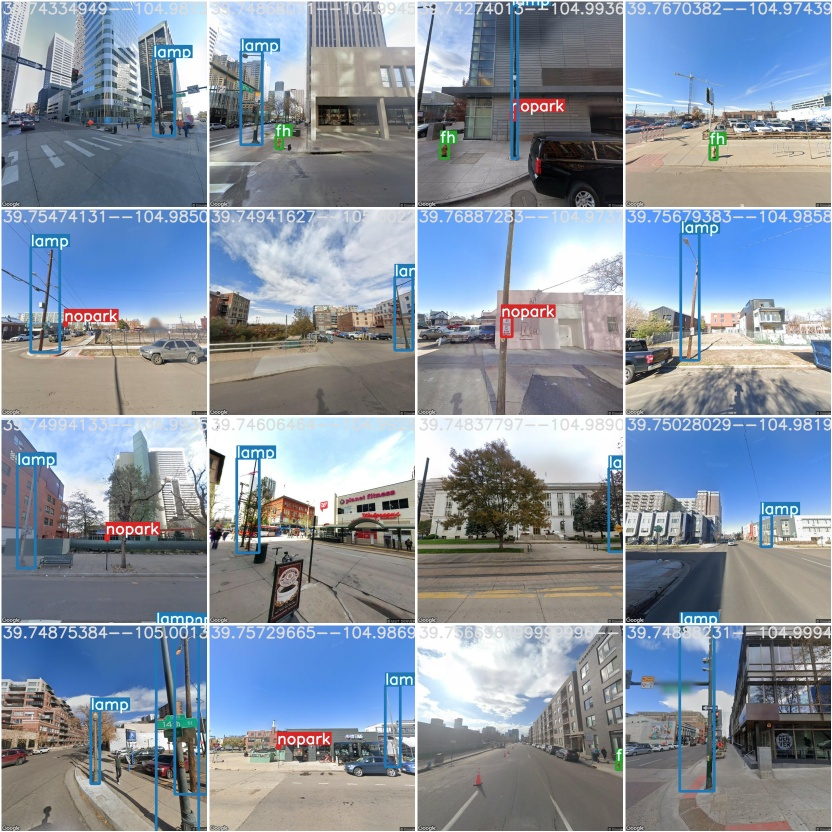

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='./test_batch0_gt.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


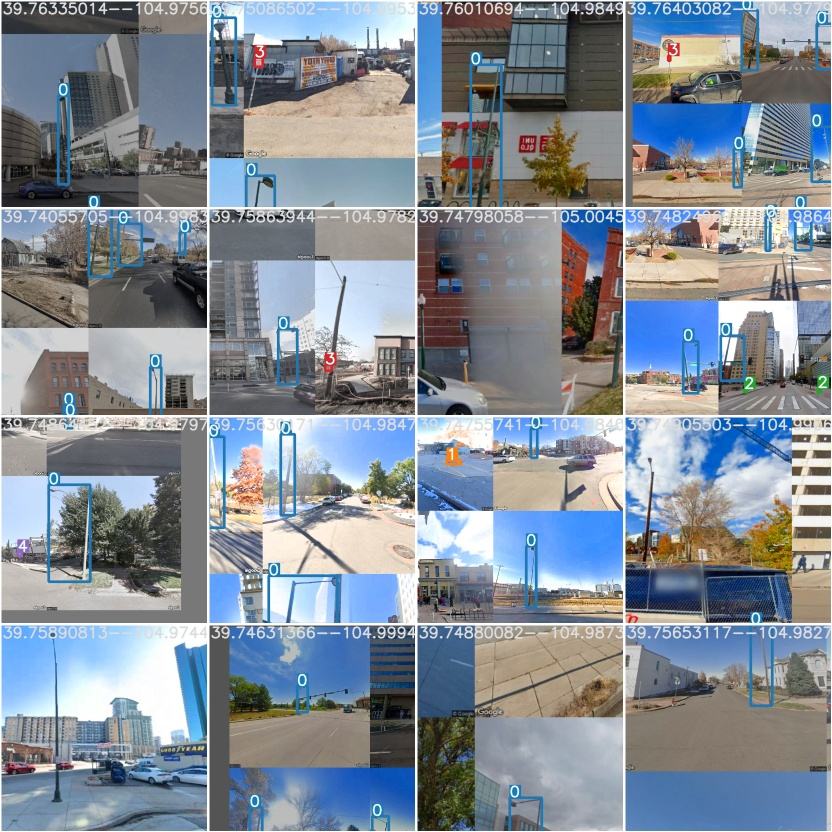

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='./train_batch2.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls weights/

best_Img2000cls5_results.pt  last_Img2000cls5_results.pt
download_weights.sh*         yolov5s.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
%cd /content/yolov5/
!python detect.py --weights weights/last_Img2000cls5_results.pt --img 416 --conf 0.4 --source Img2000cls5TrainTest/testyolo/images/

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', fourcc='mp4v', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='Img2000cls5TrainTest/testyolo/images/', view_img=False, weights='weights/last_Img2000cls5_results.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

image 1/602 Img2000cls5TrainTest/testyolo/images/39.71704951--104.9862443-135.jpg: 416x416 1 lamps, Done. (0.010s)
image 2/602 Img2000cls5TrainTest/testyolo/images/39.71729426--104.9862429-315.jpg: 416x416 1 lamps, Done. (0.011s)
image 3/602 Img2000cls5TrainTest/testyolo/images/39.71827329--104.9862382-315.jpg: 416x416 1 lamps, Done. (0.011s)
image 4/602 Img2000cls5TrainTest/testyolo/images/39.71876279999999--104.9862367-135.jpg: 416x416 2 lamps, Done. (0.011s)
image 5/602 Img2000cls5TrainTest/testyolo/images/39.71949708--104.9862368-135.jpg: 416x416 2 lamps, 1 fhs, Done. (0.009s)
image 6/602 Img2000

In [1]:
#display inference on ALL test images
# import glob
# from IPython.display import Image, display

# for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'): #assuming JPG
#     display(Image(filename=imageName))
#     print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/weights/last_Img2000cls5_results.pt /content/gdrive/My\ Drive
%cp /content/yolov5/weights/best_Img2000cls5_results.pt /content/gdrive/My\ Drive

%cp /content/yolov5/results_Img2000cls5_results.txt /content/gdrive/My\ Drive

## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)